In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

# Generamos la estructura

la función [ase.build.bulk](https://wiki.fysik.dtu.dk/ase/ase/build/build.html?highlight=build) genera estructuras bulk, los argumentos son la composición química, la estructura cristalina, el parámetro de red y si se quiere una celda convencional o primitiva. El Output es un [objeto atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms), que permitirá luego manipular sus componentes. Se puede pensar el estos objetos como listas de [objetos Atom](https://wiki.fysik.dtu.dk/ase/ase/atom.html#ase.atom.Atom), de átomos individuales

In [4]:
SiDiamond = bulk('Si', 'diamond', a=4., cubic=True)

In [5]:
printatoms = [print(at) for at in SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


In [6]:
SiDiamond[0] # te da el simbolo y la posición  del primer atomo 

Atom('Si', [0.0, 0.0, 0.0], index=0)

In [7]:
SiDiamond[1]

Atom('Si', [1.0, 1.0, 1.0], index=1)

In [8]:
SiDiamond[0].position

array([0., 0., 0.])

In [9]:
SiDiamond.cell

Cell([4.0, 4.0, 4.0])

In [10]:
SiDiamond.positions

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 2., 2.],
       [1., 3., 3.],
       [2., 0., 2.],
       [3., 1., 3.],
       [2., 2., 0.],
       [3., 3., 1.]])

Luego con la función plot_atoms podemos visualizarlos, pero la verdad es que no es muy buena, solo para visualizar la estructura rápidamente en el Jupyter Notebook

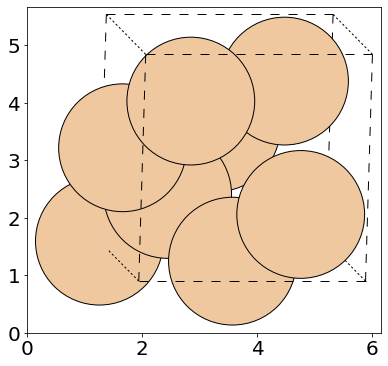

In [11]:
plot_atoms(SiDiamond, rotation='10x, 10y')

o bien, para poder rotarlo a mano (pero no se si anda en google colab)


In [12]:
#view(SiDiamond)

Una forma más presentable de visualizar las estructuras es usando por ejemplo [VESTA](http://www.jp-minerals.org/vesta/en/download.html) 

# Generamos la estructura con defectos Sustitucionales

Para poner un defecto sustitucional, basta con reemplazar un átomo del objeto atoms. Más fácil que en gmsh.

In [13]:
# hago copia de "SiDiamond", para no perderla y además poner defecto sustitucional.
SiBDiamond = SiDiamond.copy()
symbols = SiBDiamond.get_chemical_symbols()
symbols

['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


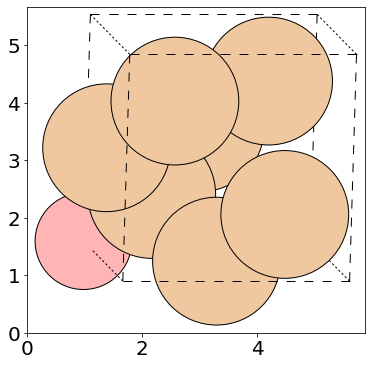

In [14]:
# Introduzco un átomo de BORO en el índice 0 de "SiBDiamond"; dopé con B en la posición [0,0,0].
symbols[0] = 'B'   # para hacerlo, modifico "symbols"
SiBDiamond.set_chemical_symbols(symbols)   # y a partir del "symbols" modificada, es que actualizo "SiBDiamond"
print_newatoms = [print(at) for at in SiBDiamond]
plot_atoms(SiBDiamond, rotation='10x, 10y')

**Aunque un poco más elegante sería**

1) pasar Objeto Atoms a una lista normal:

``` python
SiDiamondList = [at for at in SiDiamond]
```

2) cambiar el primer objeto de la lista:

``` python
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
```

y despues volver a pasarlo a objeto Atoms:

``` python
SiBDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
```

In [15]:
# Creo lista normal, con los elementos de la original "SiDiamond".
SiDiamondList = [at for at in SiDiamond]
# Con "atom" defino el átomo de B, le asigno posición que tenía el Si en "SiDiamond", y guardo en la lista "SiDiamondList".
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "SiDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir de
# lo que contiene "SiDiamondList".
SiCDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
print_newnew_atoms = [print(at) for at in SiCDiamond]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


# Tareas
1.  convergencia en puntos K y en ondas planas
2. Calcular curva E-V  y ajustar parámetro de red. ¿ Cambia mucho al cambiar un átomo solo ?
3. Calcular estructura electrónica, i.e. densidad de estados. ¿Qué cambia ? 

# Definimios la calculadora

Primero, calculamos usando la celda de Si SIN DOPAR con B.

In [18]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiDiamondExample.txt',kpts=[5,5,5])
SiDiamond.set_calculator(calc)
SiDiamond.get_potential_energy()

30.841227127871782

Segundo, calculamos usando la celda de Si DOPADA con B

In [19]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiBDiamondExample.txt',kpts=[5,5,5])
SiBDiamond.set_calculator(calc)
SiBDiamond.get_potential_energy()

15.080646295463513

**Conclusión:** Al dopar Si diamante con un átomo de B en la posición (0,0,0), *la energía potencial se reduce prácticamente a la mitad*.

# K-point convergence 

Defino las dos estructuras en las que evaluaré la convergencia en puntos K:
- $SiDiamond$, sin dopar con B.
- $SiBDiamond$, dopada con B.

In [22]:
structures = [('pure', SiDiamond, 5.0), ('wBoron', SiBDiamond, 5)] # Nombre, estructura, parámetro de red.

In [27]:
print(structures[0])

('pure', Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)), 5.0)


In [28]:
print(structures[0][0])

pure


In [32]:
kpoints = [3, 4, 5,7,9,11,13,14,15] # Grillas a ensayar
Ekpt = {} # Guardaré, para cada estructura (name), la información de las grillas en un diccionario

In [33]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt"
        calc = GPAW(mode=PW(300), txt=f'{name}_{kpt}.txt', xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Imprimo energías potenciales de $SiDiamond$

In [34]:
print(Ekpt[structures[0][0]])

[3.82942361 3.84226176 3.85515339 3.85366022 3.84680203 3.84643687
 3.84849821 3.8486624  3.8487114 ]


Imprimo energías potenciales de $SiBDiamond$

In [35]:
print(Ekpt[structures[1][0]])

[1.87559467 1.87535473 1.88508079 1.87945832 1.87788234 1.87564313
 1.87482283 1.87463    1.87466355]


**Conclusión:** De nuevo, las energías asociadas al Si dopado con B son menores.

***Convergencia*** significa que la diferencia de energía entre un cierto K y el último K, dividida por la energía del último K, es menor a un determinado margen establecido.

**Este cociente** es lo que se grafica a continuación, en función del número de puntos K.

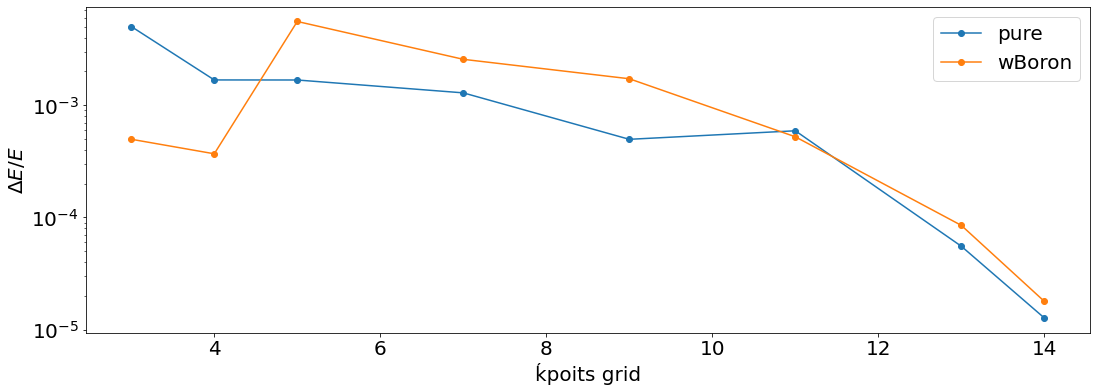

In [36]:
plots = [plt.plot(kpoints[:-1], np.abs(energies[:-1]-energies[-1])/energies[-1], '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('ḱpoits grid')
plt.legend()

**Conclusión:** Hay convergencia a partir de $K = 11$. Deberé tomar grillado de $11*11*11$.

In [37]:
KPT = 11

# cutoff convergence

A partir de aca hay que completar !

In [38]:
ecuts = [200, 250, 300, 400] # Energías cinéticas de corte (como la que habíamos usado de 300 eV arriba).
Ecutoff = {} # Guardaré, para cada estructura (name), la información de las energías de corte en un diccionario

In [39]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    for ecut in tqdm(ecuts):
      # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
      calc = GPAW(mode=PW(ecut), txt=f'{name}_{ecut}.txt', xc='PBE', kpts=[KPT,KPT,KPT])
      struc.set_calculator(calc)
      # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
      Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
Ecutoff

{'pure': array([3.85598245, 3.84828234, 3.84643687, 3.84383355]),
 'wBoron': array([1.9960631 , 1.91424633, 1.87564313, 1.851634  ])}

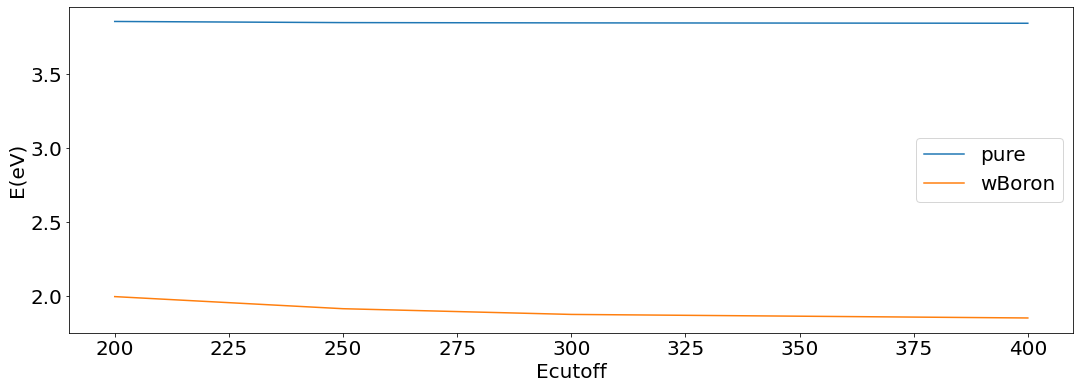

In [44]:
[plt.plot(ecuts, energies, label = struc) for struc, energies in Ecutoff.items()]
plt.ylabel('E(eV)')
plt.xlabel('Ecutoff')
plt.legend()

**Conclusión:** Hay convergencia a partir de $E = 350$. Deberé tomar energía cinética de corte $ECUT = 350$.

In [45]:
ECUT = 350

# Lattice Parameter

Inicialmente había supuesto un parámetro de red $a=5$, pero ahora probaré con 10 valores en el entorno de $a=5$.

In [60]:
latparams = {'diamond': np.linspace(4.8,5.5,10), 'wBoron': np.linspace(4.8, 5.5, 10)}

In [53]:
# Hago loop sobre los parámetros de red, y para dada estructura calculo la energía asociada a utilizar ese parámetro de red. Obendré energías en función de
# parámatro de red (en realidad cubo de parámetro de red, volumen), y así puedo obtener el parámetro de red que minimiza la energía.
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [61]:
evcurves = {struc: evcurve('Si',struc, thissizes, calc) for struc, thissizes in latparams.items() }

working on Si in diamond


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

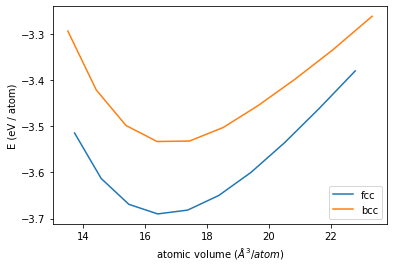

In [ ]:
for struc, evcurve in evcurves.items():
    natoms = evcurve['strucs'][-1].get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=struc)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

<AxesSubplot:>

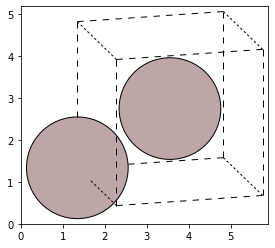

In [ ]:
plot_atoms(evcurves['bcc']['strucs'][-1], rotation='15y, 15x')

<AxesSubplot:>

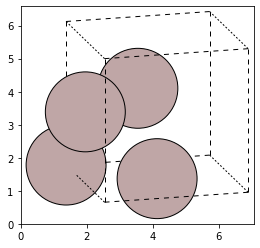

In [ ]:
plot_atoms(evcurves['fcc']['strucs'][-1], rotation='15y, 15x')

# Ecuación de Estado 

In [ ]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [ ]:
eos.fit()

(66.22762521910393, -14.759967369775243, 0.49791609505250944)

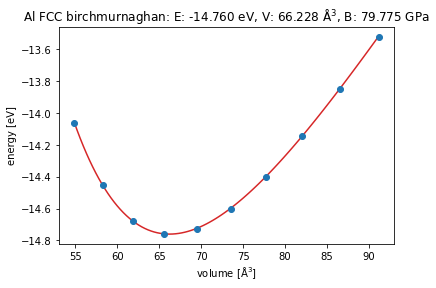

In [ ]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Al FCC ' + title)

In [ ]:
eqa = eos.v0**(1/3)

In [ ]:
eqa

4.045880589525278

# Densidad de Estados 

In [ ]:
eqstruc = bulk('Al','fcc',a=eqa, cubic=True)
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[11,11,11], txt='equilibrium.txt')
eqstruc.set_calculator(calc)
eqstruc.get_potential_energy()

e,dos = eqstruc.calc.get_dos(npts=500)
ef = eqstruc.calc.get_fermi_level()

Text(0, 0.5, 'DOS')

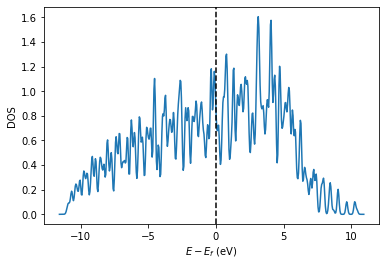

In [ ]:
plt.plot(e-ef,dos)
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')

In [ ]:
eqstruc.calc.write('Alfcceq.gpw')

In [ ]:
bscalc = GPAW('Alfcceq.gpw').fixed_density(nbands=20, symmetry='off', txt='bs.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [ ]:
bs = bscalc.band_structure()

In [ ]:
bs = bs.subtract_reference()

Text(0, 0.5, '$E-E_f$ (eV)')

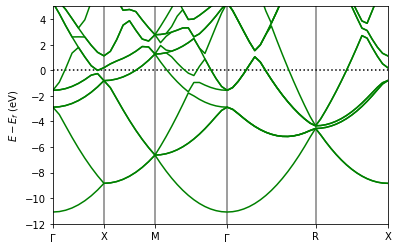

In [ ]:
ax = bs.plot(emin=-12, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')